In [2]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix, coo_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv
import hdbscan

large_file_path = "./../../../large_data_files"
k_neighbors = 100
k_neighbors += 1

In [ ]:
patient_icd_sparse_path = "./../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p"
pdata = pickle.load(open(patient_icd_sparse_path, "rb"))
pdata.shape

In [ ]:
#Build L Matrix
ANNOY_PATH = "../../../large_data_files"
annoy_path = os.path.join(ANNOY_PATH, "200214_patient_similarity_clusters_default.ann")

cos_knn_tree = AnnoyIndex(pdata.shape[1], "angular")
cos_knn_tree.load(annoy_path)

gamma = 2
print("Building dense data matrix with k={} nn...".format(k_neighbors))
A = np.zeros((pdata.shape[0], pdata.shape[0]))
for i in tqdm(range(pdata.shape[0])):
    nn_idxs = cos_knn_tree.get_nns_by_item(i, k_neighbors)[1:]
    cos_distances = [cos_knn_tree.get_distance(i, nn) for nn in nn_idxs]
    rbf_distances = [np.exp(-gamma*cos_dist**2) for cos_dist in cos_distances]
    A[i, nn_idxs] = rbf_distances

In [ ]:
knn_adj = {}
for i in tqdm(range(A.shape[0])):
    nn_idx = set(np.nonzero(A[i])[0])
    knn_adj[i] = nn_idx
    
for i in tqdm(range(A.shape[0])):
    nns = knn_adj[i]
    for nn in nns:
        if i not in knn_adj[nn]:
            A[i, nn] = 0

pickle.dump(csr_matrix(A), open("./data/A_mknn_K{}_CSR.p".format(k_neighbors - 1), "wb"))

# A loading

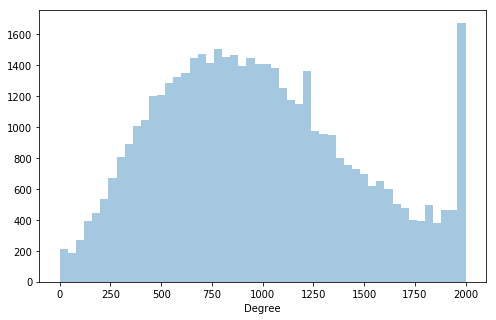

In [4]:
k_neighbors = 2000
A = pickle.load(open("./../../../large_data_files/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")
plt.savefig("./figures/mknn_featdist_K{}_RAW.png".format(k_neighbors))

### A: remove empty patients and outliers

<class 'scipy.sparse.csr.csr_matrix'>
(46498, 46498)


[Text(0.5,0,'Degree')]

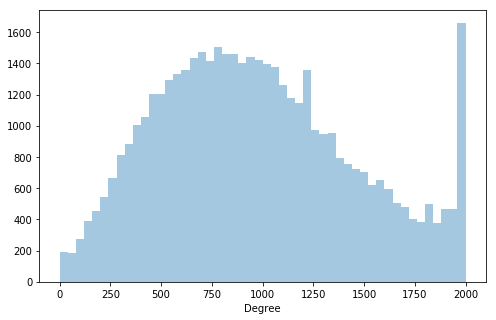

In [5]:
###Remove empty cols and rows
rows_with_vals = np.unique(A.indices)

A_nonempty = A[rows_with_vals][:, rows_with_vals]
print(type(A_nonempty))
print(A_nonempty.shape)

plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A_nonempty.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")

In [6]:
###Remove outliers
patient_degrees = np.count_nonzero(A_nonempty.toarray(), axis=0)
print(patient_degrees.shape)

(46498,)


In [7]:
threshold = k_neighbors
degree_threshold_idx = np.argwhere(patient_degrees < threshold)[:, 0]
print(degree_threshold_idx)
print(degree_threshold_idx.shape)

[    0     1     2 ... 46495 46496 46497]
(45182,)


(46498, 46498) (45182, 45182)


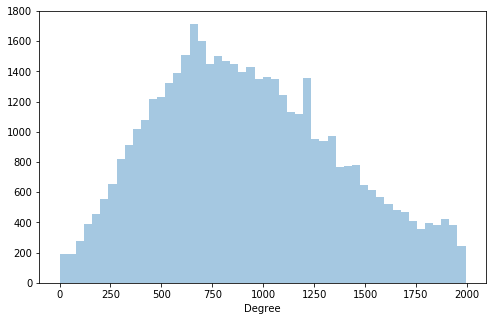

In [47]:
A_cleaned = A_nonempty[degree_threshold_idx][:, degree_threshold_idx]
print(A_nonempty.shape, A_cleaned.shape)

plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A_cleaned.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")
plt.savefig("./figures/mknn_featdist_K{}_emptyandoutliersremoved.png".format(k_neighbors))

<Figure size 432x288 with 0 Axes>

In [18]:
pickle.dump(csr_matrix(A_cleaned), open("./../../../large_data_files/A_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

In [19]:
A = pickle.load(open("./../../../large_data_files/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
print(A.shape)

(45182, 45182)


# D

In [20]:
D = np.zeros((A.shape[0], A.shape[0]))
for i in tqdm(range(A.shape[0])):
    D[i, i] = np.sum(A[i])
    
pickle.dump(csr_matrix(D), open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

100%|██████████| 45182/45182 [00:10<00:00, 4398.45it/s]


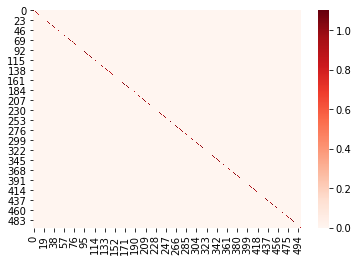

In [45]:
D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
sns.heatmap(D[:500, :500].log1p().log1p().log1p().toarray(), cmap="Reds")

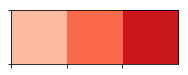

In [33]:
sns.palplot(sns.color_palette("Reds", n_colors=3))

# D_mc

In [22]:
k_neighbors = 2000

In [23]:
diag_idx = np.diag_indices(D.shape[0])
D_mean = np.mean(D[diag_idx])

D_mc = D.copy()
D_mc[diag_idx] = D[diag_idx] + D_mean
print(np.mean(D_mc[diag_idx]), np.mean(D[diag_idx]))

160.6206766131759 80.31033830658794


In [24]:
pickle.dump(csr_matrix(D_mc), open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

# D_inv_sqrt

In [25]:
D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
print(D.shape, D_mc.shape)

(45182, 45182) (45182, 45182)


In [26]:
def get_inv_sqrt(d):
    nonzero_idx = np.nonzero(d)
    D_diag_sqrt_inv = 1.0/np.sqrt(d[nonzero_idx])
    D_inv_sqrt = d.copy()
    D_inv_sqrt[nonzero_idx] = D_diag_sqrt_inv
    return D_inv_sqrt

D_inv_sqrt = get_inv_sqrt(D)
D_mc_inv_sqrt = get_inv_sqrt(D_mc)

In [27]:
pickle.dump(D_inv_sqrt, open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))
pickle.dump(D_mc_inv_sqrt, open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))

# Compute normalized L

In [28]:
k_neighbors = 2000

In [29]:
A = pickle.load(open("./../../../large_data_files/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
print(A.shape, D.shape, D_mc.shape)

L = D_inv_sqrt.dot(A.dot(D_inv_sqrt))
L_mc = D_mc_inv_sqrt.dot(A.dot(D_mc_inv_sqrt))

pickle.dump(csr_matrix(L), open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "wb"))
pickle.dump(csr_matrix(L_mc), open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

(45182, 45182) (45182, 45182) (45182, 45182)


In [30]:
print(L.shape, L_mc.shape)

(45182, 45182) (45182, 45182)


# Eigen Decomposition

In [31]:
evecs=50
L_evals, L_evecs = scipy.sparse.linalg.eigsh(L, k=evecs, which="LM")
L_mc_evals, L_mc_evecs = scipy.sparse.linalg.eigsh(L_mc, k=evecs, which="LM")
pickle.dump(L_evecs, open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'wb'))
pickle.dump(L_mc_evecs, open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "wb"))
pickle.dump(L_evals, open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))
pickle.dump(L_mc_evals, open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))

[ 1.          0.9998497   0.92732817  0.90785311  0.88933743  0.88095456
  0.83915946  0.81860116  0.73231867  0.7093878   0.70231609  0.66675754
  0.65023243  0.64293373  0.63889631  0.61387624  0.58075589  0.55546652
  0.53704593  0.53557277  0.53543944  0.52001813  0.51959169  0.50576573
  0.50091899  0.49921913  0.49427005  0.48824308  0.48168461  0.47177675
  0.47002137  0.46102819  0.45478353  0.44372971  0.44049755  0.43361993
  0.43157127  0.42477834  0.42081767  0.41602439  0.41398782  0.40992295
  0.4080404   0.40281182  0.40081328  0.39635621  0.39028869  0.38961744
  0.38405645 -0.39889951]
[0.79820765 0.64909943 0.63671329 0.56314511 0.48794017 0.47916282
 0.43378738 0.40331573 0.36953029 0.35545269 0.34999924 0.34542617
 0.32396076 0.29316968 0.28765595 0.27906199 0.27001638 0.26933342
 0.2584566  0.25602508 0.25155018 0.24753878 0.24521216 0.23847034
 0.23310536 0.22257145 0.2171287  0.21144081 0.20893018 0.20349509
 0.20256252 0.19871733 0.19256251 0.1900283  0.18881095

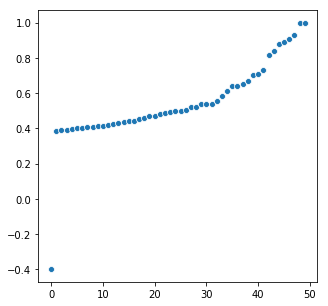

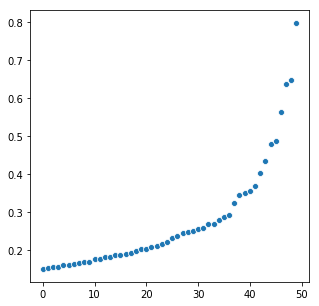

In [32]:
print(np.flip(L_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)

print(np.flip(L_mc_evals))
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_mc_evals)

In [ ]:
k_neighbors = 50
if use_mc:
    L = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb")).toarray()
else:
    L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb")).toarray()

print("Found nans:", np.any(np.isnan(L)))

evals=100
L_evals, L_evecs = scipy.sparse.linalg.eigsh(L, k=evals + 1, which="LM")

In [ ]:
L_nan_idxs = np.argwhere(np.isnan(L_evals))
print("Nans shape:", L_nan_idxs.shape)

plt.figure(figsize=(10,10))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)
ax.set(xlabel="Eigenvalue Number 0 - {}".format(evals + 1))
if use_mc:
    plt.savefig("./figures/evals_L_mc_evals{}_K{}.png".format(evals, k_neighbors))
else:
    plt.savefig("./figures/evals_L_evals{}_K{}.png".format(evals, k_neighbors))

# Top K Eigenvectors

In [ ]:
drop_k_evals = 16
top_k_evecs=3
knn_clusters = 4
lc=100
visualizer = Visualizer()

In [ ]:
print("Mean Correction?", use_mc)
print("K", k_neighbors)
print("drop_k_evals", drop_k_evals)
print("top_k_evecs", top_k_evecs)
print("knn_clusters", knn_clusters)

In [ ]:
X_top_k = L_evecs[:, -drop_k_evals-top_k_evecs:-drop_k_evals]
L_evecs_lengths_top_k = np.linalg.norm(X_top_k, axis=1)
Y_top_k = X_top_k / L_evecs_lengths_top_k[:, None]

print(X_top_k.shape)
print(Y_top_k.shape)

In [ ]:
if use_mc:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))
else:
    Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))
    Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'rb'))

In [ ]:
Y_umap_2d = visualizer.umap_embedding(Y_top_k, n_components=2, lc=lc)
Y_umap_3d = visualizer.umap_embedding(Y_top_k, n_components=3, lc=lc)

if use_mc:
    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_mc_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))
else:
    pickle.dump(Y_umap_2d, open("./data/Y_umap_2d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))
    pickle.dump(Y_umap_3d, open("./data/Y_umap_3d_K{}_topkevecs{}_lc{}.p".format(k_neighbors, top_k_evecs, lc), 'wb'))

In [ ]:
if use_mc:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), 'rb'))
else:
    Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), 'rb'))

In [ ]:
Y_kmeans_top_k = KMeans(n_clusters=knn_clusters).fit(Y_top_k)
Y_cluster_labels = Y_kmeans_top_k.labels_

if use_mc:
    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), "wb"))
else:
    pickle.dump(Y_cluster_labels, open("./data/cluster_labels_K{}_knn{}_topkevecs{}.p".format(k_neighbors, knn_clusters, top_k_evecs), "wb"))
print("Cluster labels:", np.unique(Y_cluster_labels))

# Eigenvector Analysis

In [ ]:
evecs_to_plot=5

In [ ]:
print("Mean Correction?", use_mc)
print("K", k_neighbors)
print("drop_k_evals", drop_k_evals)
print("top_k_evecs", top_k_evecs)
print("knn_clusters", knn_clusters)
print("evecs_to_plot", evecs_to_plot)

In [ ]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)
ax.set(xlabel="Eigenvalue Number 0 - {}".format(evals + 1))

In [ ]:
# X_top_k = L_evecs[:, -drop_k_evals-top_k_evecs:-drop_k_evals]
k_evecs = L_evecs[:, -evecs_to_plot:]
evec_cols = ["Evec_{}".format(i) for i in range(evecs_to_plot)]
evec_df = pd.DataFrame(k_evecs, columns=evec_cols)

print(evec_df.describe())

In [ ]:
quantiles = []
for i in range(evecs_to_plot):
    q1 = evec_df["Evec_{}".format(i)].quantile(0.25)
    q2 = evec_df["Evec_{}".format(i)].quantile(0.75)
    quantiles.append((q1, q2))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
evec_i = 3

prev_colname = "Evec_{}".format(evec_i)
next_colname = "Evec_{}".format(evec_i + 1)

prev_quantiles = evec_df[(evec_df[prev_colname] >= quantiles[evec_i][0]) & 
                         (evec_df[prev_colname] <= quantiles[evec_i][1])]
sns.distplot(prev_quantiles[prev_colname], kde=False, label=prev_colname, ax=axes[0])
sns.distplot(prev_quantiles[next_colname], kde=False, label=next_colname, ax=axes[0])
axes[0].legend()

next_quantiles = evec_df[(evec_df[next_colname] >= quantiles[evec_i + 1][0]) & 
                         (evec_df[next_colname] <= quantiles[evec_i + 1][1])]
sns.distplot(next_quantiles[prev_colname], kde=False, label=prev_colname, ax=axes[1])
sns.distplot(next_quantiles[next_colname], kde=False, label=next_colname, ax=axes[1])
axes[1].legend()

if use_mc:
    plt.savefig("./figures/evecs_distplot_{}vs{}_L_mc_K{}.png".format(evec_i, evec_i+1, k_neighbors))
else:
    plt.savefig("./figures/evecs_distplot_{}vs{}_L_K{}.png".format(evec_i, evec_i+1, k_neighbors))


In [ ]:
for evec_i in range(evecs_to_plot - 1):
    evec_colname = "Evec_{}".format(evec_i)
    evec_quantiles = evec_df[(evec_df[evec_colname] >= quantiles[evec_i][0]) & 
                             (evec_df[evec_colname] <= quantiles[evec_i][1])]
    sns.pairplot(evec_quantiles[["Evec_{}".format(evec_i), "Evec_{}".format(evec_i+1)]])
#     if use_mc:
#         plt.savefig("./figures/evecs_pairplot_{}vs{}_L_mc_K{}.png".format(evec_i, evec_i+1, k_neighbors))
#     else:
#         plt.savefig("./figures/evecs_pairplot_{}vs{}_L_K{}.png".format(evec_i, evec_i+1, k_neighbors))

#MAKE THIS PLOT FUNCTION A BIT MORE GENERAL. U NOTICE HOW EVEC4 vs EVEC3 SAYS A LOT ABOUT HOW THE CLUSTERS CAN FORM

In [ ]:
sns.pairplot(evec_quantiles.iloc[:2000])

# Other

In [ ]:
Y_umap_2d
Y_cluster_labels
Y_umap_2d[:, 0]

In [ ]:
alpha = 1

if use_mc:
    filename_2d = "./figures/umap2d_mc_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)
    filename_3d = "./figures/umap3d_mc_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)
else:
    filename_2d = "./figures/umap2d_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)
    filename_3d = "./figures/umap3d_K{}_topkevecs{}_lc{}_knn{}".format(k_neighbors, top_k_evecs, lc, knn_clusters)   

data2d = {"umap_1": Y_umap_2d[:, 0].tolist(), 
          "umap_2": Y_umap_2d[:, 1].tolist(), 
          "cluster": Y_cluster_labels.tolist()}

data3d = {"umap_1": Y_umap_3d[:, 0].tolist(), 
          "umap_2": Y_umap_3d[:, 1].tolist(), 
          "umap_3": Y_umap_3d[:, 2].tolist(), 
          "cluster": Y_cluster_labels.tolist()}

In [ ]:
plt.figure(figsize=(15,15))
ax2d = sns.scatterplot(x='umap_1', y='umap_2', hue='cluster', palette="bright", data=df2d)
plt.legend(loc="upper left")

## Standardized Decomposition

In [ ]:
L_standardized = pickle.load(open("L_standardized_sym_K{}_CSR.p".format(k_neighbors - 1), "rb"))
L_standardized

In [ ]:
L_std = np.std(L, axis=0)
L_mean = np.mean(L, axis=0)
print(np.nonzero(L_std)[0])
print(np.nonzero(L_mean)[0])
print(np.all(np.nonzero(L_std)[0] == np.nonzero(L_mean)[0]))
print("^ This means mean and std are nonzero at exactly the same places...")

L_standardized = np.subtract(L, L_mean, where=L_std!=0)
L_standardized = np.divide(L, L_std, where=L_std!=0)

In [ ]:
print(np.mean(L_standardized[:, 67]))
print(np.std(L_standardized[:, 67]))

In [ ]:
pickle.dump(csr_matrix(L_standardized), open("L_standardized_sym_K{}_CSR.p".format(k_neighbors - 1), "wb"))

In [ ]:
e_std = 100
L_standardized_evals, L_standardized_evecs = scipy.sparse.linalg.eigsh(L_standardized, k=e_std)

L_standardized_nan_idxs = np.argwhere(np.isnan(L_standardized_evals))
print("Nans shape:", L_standardized_nan_idxs.shape)

plt.figure(figsize=(10,10))
sns.scatterplot(range(L_standardized_evals.shape[0]), L_standardized_evals)
plt.savefig("eigen_vals_eigs{}_L_standardized_K{}.png".format(e_std, k_neighbors - 1))

In [ ]:
pickle.dump(L_standardized_evals, open("L_standardized_evals_eigs{}_K{}.p".format(e_std, k_neighbors - 1), "wb"))

In [ ]:
a = np.array([[1,1,1],[2,2,2],[3,3,3]])
b = np.array([1,2,3])

print(a / b[:, None])

# Cluster

In [ ]:
X = L_evecs
L_evecs_lengths = np.linalg.norm(X, axis=1)

Y = X / L_evecs_lengths[:, None]

In [ ]:
Y_pca = PCA().fit(Y.T)

In [ ]:
n_feats = 5
print(np.sum(Y_pca.explained_variance_ratio_[:n_feats]))

In [ ]:
Y_pca_feats = Y_pca.components_[:n_feats].T
Y_pca_feats.shape

In [ ]:
n_clusters = 3
Y_kmeans = KMeans(n_clusters=n_clusters).fit(Y_pca_feats)
Y_cluster_labels = Y_kmeans.labels_
np.unique(Y_cluster_labels)

In [ ]:
visualizer = Visualizer()
Y_umap_2d = visualizer.umap_embedding(Y_pca_feats, n_components=2)
Y_umap_3d = visualizer.umap_embedding(Y_pca_feats, n_components=3)

pickle.dump(Y_umap_2d, open("Y_umap_2d_pca{}.p".format(n_feats), 'wb'))
pickle.dump(Y_umap_3d, open("Y_umap_3d_pca{}.p".format(n_feats), 'wb'))

In [ ]:
Y_umap_2d = pickle.load(open("Y_umap_2d_pca{}.p".format(n_feats), 'rb'))
Y_umap_3d = pickle.load(open("Y_umap_3d_pca{}.p".format(n_feats), 'rb'))

alpha = 1
visualizer.plot2d(
    X=Y_umap_2d, 
    filename="Patient_Clusters_2D_spectral_K{}_eig{}_pca{}_clusters{}".format(k_neighbors - 1, eigs, n_feats, n_clusters), 
    colors=Y_cluster_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename="Patient_Clusters_3D_spectral_K{}_eig{}_pca{}_clusters{}".format(k_neighbors - 1, eigs, n_feats, n_clusters), 
    colors=Y_cluster_labels,
    alpha = alpha
)

# HDBSCAN

In [ ]:
n_feats = 8
minclustersize = 10

Y_pca_feats = Y_pca.components_[:n_feats].T

hdbscanner = hdbscan.HDBSCAN(min_cluster_size=minclustersize).fit(Y_pca_feats)
hdbscan_labels = hdbscanner.fit_predict(Y_pca_feats)
np.unique(hdbscan_labels, return_counts=True)

In [ ]:
visualizer = Visualizer()
Y_umap_2d = visualizer.umap_embedding(Y_pca_feats, n_components=2)
Y_umap_3d = visualizer.umap_embedding(Y_pca_feats, n_components=3)

pickle.dump(Y_umap_2d, open("Y_umap_2d_pca{}.p".format(n_feats), 'wb'))
pickle.dump(Y_umap_3d, open("Y_umap_3d_pca{}.p".format(n_feats), 'wb'))

In [ ]:
Y_umap_2d = pickle.load(open("Y_umap_2d_pca{}.p".format(n_feats), 'rb'))
Y_umap_3d = pickle.load(open("Y_umap_3d_pca{}.p".format(n_feats), 'rb'))

alpha = 1
visualizer.plot2d(
    X=Y_umap_2d, 
    filename="Patient_Clusters_2D_spectral_HDB_K{}_eig{}_pca{}_minclustersize{}".format(k_neighbors - 1, eigs, n_feats, minclustersize), 
    colors=hdbscan_labels,
    alpha = alpha
)

visualizer.plot3d(
    X=Y_umap_3d, 
    filename="Patient_Clusters_3D_spectral_HDB_K{}_eig{}_pca{}_minclustersize{}".format(k_neighbors - 1, eigs, n_feats, minclustersize), 
    colors=hdbscan_labels,
    alpha = alpha
)

# Misc

In [ ]:
icd_idx = 0
icd_row = A_sym[icd_idx]
has_icd = np.nonzero(icd_row)[1]
has_icd

In [ ]:
def sort_pdata(pdata, unwanted = set([])):
    icd_x_patients = pdata.T
    sorted_idx = []
    seen = set([])

    for icd_idx in tqdm(range(icd_x_patients.shape[0])):
        if icd_idx in unwanted:
            continue
        icd_row = icd_x_patients[icd_idx]
        has_icd = set(np.nonzero(icd_row)[1])
        has_icd -= seen
        sorted_idx += list(has_icd)
        seen.update(sorted_idx)
        
    icd_x_patients_sorted = pdata[sorted_idx].T
    print(len(seen))
    return icd_x_patients_sorted

A_sorted = sort_pdata(A_sym)
A_sorted[A_sorted > 0] = 1

In [ ]:
plt.figure(figsize=(40, 20))
sns.heatmap(A_sorted.toarray()[:2000, :2000])
plt.savefig("heatmap_A_K{}.png".format(k_neighbors - 1))